# Validation of PRMS6 Surface, Soil, Groundwater, and Streamflow BMI Coupling

The purpose of this notebook is to show an example coupling of the complete set of PRMS6 BMIs; Surface, Soil, Groundwater, and Streamflow. The PRMS example Pipestem is used and the results of the coupled solution and straight PRMS6 solution are compared for couple validation.  Code repositories used in this demo are available at the links below.

* The surface-BMI builds on PRMS6 by Parker Norton (USGS)
    * https://github.com/nhm-usgs/prms/releases/tag/6.0.0_bmi-testing
* The Fortran BMIs by Rich McDonald and Steve Markstrom (USGS)
    * https://github.com/nhm-usgs/bmi-prms6-surface
    * https://github.com/nhm-usgs/bmi-prms6-soil
    * https://github.com/nhm-usgs/bmi-prms6-groundwater
    * https://github.com/nhm-usgs/bmi-prms6-streamflow
* The CSDMS-BMI-PyMT package by Mark Piper and Eric Hutton (CSDMS, CU-Boulder)
    * https://github.com/pymt-lab/pymt_prms_surface
    * https://github.com/pymt-lab/pymt_prms_soil
    * https://github.com/pymt-lab/pymt_prms_groundwater
    * https://github.com/pymt-lab/pymt_prms_streamflow
* More info about PyMT
    * https://csdms.github.io/pymt/

|---|---|---|
|:--:|:--:|:--:|
|![](https://avatars0.githubusercontent.com/u/49734319?s=200&v=4) |![](https://csdms.colorado.edu/mediawiki/images/CSDMS-logo-color-tagline-ver_low.png)| ![](https://bmi.readthedocs.io/en/latest/_images/bmi-logo-header-text.png)|

---

## Demo of the Pipestem project

In [1]:
%matplotlib inline
import numpy as np
from pymt.models import PRMSSurface, PRMSSoil, PRMSGroundwater, PRMSStreamflow
from pathlib import Path
import geopandas as gpd
import pandas as pd
import helper

➡ models: Avulsion, Plume, Sedflux3D, Subside, PRMSSurface, PRMSStreamflow, PRMSSoil, PRMSGroundwater, FrostNumber, Ku, Hydrotrend, Cem, Waves


In [2]:
run_dir = '../prms/pipestem'
config_surf= 'control_surface.simple1'
config_soil = 'control_soil.simple1'
config_gw = 'control_groundwater.simple1'
config_sf = 'control_streamflow.simple1'
print(Path(run_dir).exists())
print((Path(run_dir) / config_surf).exists())
print((Path(run_dir) / config_soil).exists())
print((Path(run_dir) / config_gw).exists())
print((Path(run_dir) / config_sf).exists())
msurf = PRMSSurface()
msoil = PRMSSoil()
mgw = PRMSGroundwater()
msf = PRMSStreamflow()

print(msurf.name, msoil.name, mgw.name, msf.name)


True
True
True
True
True
prms6-surface-BMI prms6-BMI-SOIL prms6-groundwater-BMI prms6-streamflow-BMI


---
Surface and Soil exchange functions

---

In [3]:
soil_input_cond_vars = ['soil_rechr_chg', 'soil_moist_chg']

surf2soil_vars = ['hru_ppt', 'hru_area_perv', 'hru_frac_perv', 'dprst_evap_hru', 
                   'dprst_seep_hru', 'infil', 'sroff','potet', 'hru_intcpevap', 
                   'snow_evap', 'snowcov_area', 'soil_rechr', 'soil_rechr_max', 
                   'soil_moist', 'soil_moist_max', 'hru_impervevap' , 
                   'srunoff_updated_soil','transp_on']

soil2surf_vars = ['infil', 'sroff', 'soil_rechr', 'soil_moist']

surf2gw_vars = ['pkwater_equiv', 'dprst_seep_hru', 'dprst_stor_hru', 'hru_intcpstor',
               'hru_impervstor', 'sroff']

soil2gw_vars = ['soil_moist_tot', 'soil_to_gw', 'ssr_to_gw', 'ssres_flow']

surf2sf_vars = ['potet', 'swrad', 'sroff']

soil2sf_vars = ['ssres_flow']

gw2sf_vars = ['gwres_flow']

def soilinput(msurf, msoil, exch_vars, cond_vars, dprst_flag, imperv_flag):
    for var in exch_vars:
        msoil.set_value(var, msurf.get_value(var))
    if dprst_flag in [1, 3] or imperv_flag in [1, 3]:
        for var in cond_vars:
            msoil.set_value(var, msurf.get_value(var))

def soil2surface(msoil, msurf, exch_vars):
    for var in exch_vars:
        msurf.set_value(var, msoil.get_value(var))
        
def gwinput(msurf, msoil, mgw, surf_vars, soil_vars):
    for var in surf_vars:
        mgw.set_value(var, msurf.get_value(var))
    for var in soil_vars:
        mgw.set_value(var, msoil.get_value(var))
        
def sfinput(msurf, msoil, mgw, msf, surf_vars, soil_vars, gw_vars):
    for var in surf_vars:
        msf.set_value(var, msurf.get_value(var))
    for var in soil_vars:
        msf.set_value(var, msoil.get_value(var))
    for var in gw_vars:
        msf.set_value(var, mgw.get_value(var))

dprst_flag = msoil.get_value('dyn_dprst_flag')
imperv_flag = msoil.get_value('dyn_imperv_flag')

def update_coupled(msurf, msoil, mgw, msf, dprst_flag, imperv_flag):
    msurf.update()
    soilinput(msurf, msoil, surf2soil_vars, soil_input_cond_vars, dprst_flag, imperv_flag)
    msoil.update()
    soil2surface(msoil, msurf, soil2surf_vars)
    gwinput(msurf, msoil, mgw, surf2gw_vars, soil2gw_vars)
    mgw.update()
    sfinput(msurf, msoil, mgw, msf, surf2sf_vars, soil2sf_vars, gw2sf_vars)
    msf.update()        

In [4]:
msurf.initialize(config_surf, run_dir)
msoil.initialize(config_soil, run_dir)
mgw.initialize(config_gw, run_dir)
msf.initialize(config_sf, run_dir)

---
Create a function of the coupled update() command

---

In [5]:
# Get time information from the model.
print(f'Start time Surface/Soil: {msurf.start_time}/{msoil.start_time}')
print(f'End time Surface/Soil: {msurf.end_time}/{msoil.end_time}')
print(f'Current time Surface/Soil: {msurf.end_time}/{msoil.end_time}')
print('Nowtime Surface/Soil:', msoil.var['nowtime'].data)#, msoil.var['nowtime'].data)

Start time Surface/Soil: 0.0/0.0
End time Surface/Soil: 731.0/731.0
Current time Surface/Soil: 731.0/731.0
Nowtime Surface/Soil: [1980    1    1    0    0    0]


---
Run the coupled BMI

---

In [6]:
for i in range(int(msurf.start_time),int(msurf.end_time)):
    update_coupled(msurf, msoil, mgw, msf, dprst_flag, imperv_flag)

---
Read the pipestem shapefile and reorder HRUs to match HRU order in pipestem example

---

In [8]:
# CSDMS JupyterHub set path to HRU and streamsegment shapefiles
hru_shp = '/data/prms/GIS/nhru_10U.shp'
hru_strmseg = '/data/prms/GIS/nsegment_10U.shp'
# set path to Gridmet weights file for mapping Gridmet gridded data to HRU
weight_file = '/data/prms/weights.csv'

# If using notebook not in CSDMS JupyterHub.  See README for instruction on where to 
# get the data and  uncomment out the following lines
hru_shp = './GIS/nhru_10U.shp'
hru_strmseg = './GIS/nsegment_10U.shp'
# set path to Gridmet weights file for mapping Gridmet gridded data to HRU
weight_file = './GIS/weights.csv'

gdf_ps = helper.get_gdf(hru_shp, msurf)

In [9]:
msurf.finalize()
msoil.finalize()
mgw.finalize()
msf.finalize()

---
Open output from PRMS6 and the Surface and Soil BMI's for comparison plots

To generate the output from the prms model (ex. not the BMI versions) run the following commands in a terminal with the prms6-bmi environment activated:

``` bash
cd prms/pipestem
prms -C control_prms.simple1

```

---

In [10]:
import xarray as xr
soil_file = Path('../prms/pipestem/output/summary_soil_daily.nc')
surf_file = Path('../prms/pipestem/output/summary_surf_daily.nc')
sf_file = Path('../prms/pipestem/output/summary_sf_daily.nc')
prms_file = Path('../prms/pipestem/output/summary_prms_daily.nc')
clim_file = Path('../prms/pipestem/daymet.nc')
dsoil = xr.open_dataset(soil_file)
dprms = xr.open_dataset(prms_file)
dsurf = xr.open_dataset(surf_file)
dstrm = xr.open_dataset(sf_file)
clim = xr.open_dataset(clim_file)

In [11]:
clim_date_min = clim.time.min().values
clim_date_max = clim.time.max().values
print(clim_date_min, clim_date_max)
# clim

1980-01-01T00:00:00.000000000 2016-12-31T00:00:00.000000000


In [12]:
sim_start_date = dsoil.time.min()
sim_end_date = dsoil.time.max()

In [13]:
dsoil

<xarray.Dataset>
Dimensions:              (nhru: 14, nsegment: 7, time: 731)
Coordinates:
  * time                 (time) datetime64[ns] 1980-01-01 ... 1981-12-31
Dimensions without coordinates: nhru, nsegment
Data variables:
    nhm_id               (nhru) int32 ...
    nhm_seg              (nsegment) int32 ...
    hru_actet            (time, nhru) float32 ...
    hru_impervevap       (time, nhru) float32 ...
    hru_intcpevap        (time, nhru) float32 ...
    snow_evap            (time, nhru) float32 ...
    perv_actet           (time, nhru) float32 ...
    slow_flow            (time, nhru) float32 ...
    recharge             (time, nhru) float32 ...
    soil_moist           (time, nhru) float32 ...
    soil_moist_tot       (time, nhru) float32 ...
    soil_to_gw           (time, nhru) float32 ...
    ssr_to_gw            (time, nhru) float32 ...
    ssres_flow           (time, nhru) float32 ...
    dprst_seep_hru       (time, nhru) float64 ...
    dprst_evap_hru       (time, nhru) float32 ...
    infil                (time, nhru) float32 ...
    sroff                (time, nhru) float32 ...
    dunnian_flow         (time, nhru) float32 ...
    pkwater_equiv        (time, nhru) float64 ...
    snowmelt             (time, nhru) float32 ...
    soil_rechr           (time, nhru) float32 ...
    contrib_fraction     (time, nhru) float32 ...
    potet                (time, nhru) float32 ...
    basin_potet          (time) float64 ...
    basin_sroff          (time) float64 ...
    gwres_flow           (time, nhru) float32 ...
    gw_in_soil           (time, nhru) float64 ...
    gw_in_ssr            (time, nhru) float64 ...
    hru_outflow          (time, nhru) float64 ...
    seg_gwflow           (time, nsegment) float64 ...
    seg_sroff            (time, nsegment) float64 ...
    seg_ssflow           (time, nsegment) float64 ...
    seg_inflow           (time, nsegment) float64 ...
    seg_outflow          (time, nsegment) float64 ...
    seg_upstream_inflow  (time, nsegment) float64 ...

In [14]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

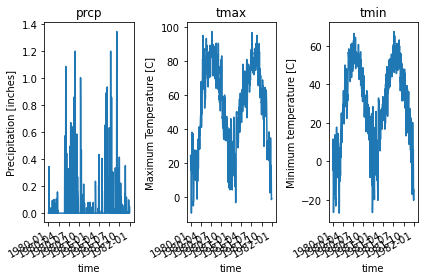

In [15]:
import matplotlib.pyplot as plt
import matplotlib
from helper import plot_climate
matplotlib.rc('axes.formatter', useoffset=False)
fig, ax = plt.subplots(ncols=3)
t_hru = 13
plot_climate(clim, t_hru, 'prcp', sim_start_date, sim_end_date, ax[0])
plot_climate(clim, t_hru, 'tmax', sim_start_date, sim_end_date, ax[1])
plot_climate(clim, t_hru, 'tmin', sim_start_date, sim_end_date, ax[2])
plt.tight_layout()
plt.show()

---
The variables plotted below are the variables that are calculated in both the Surface and Soil BMIs and exchanged between both BMIs

---

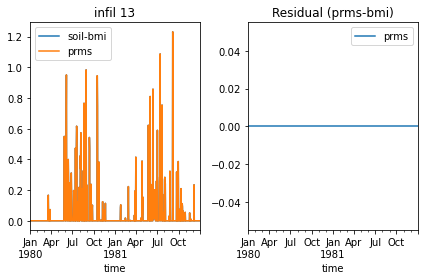

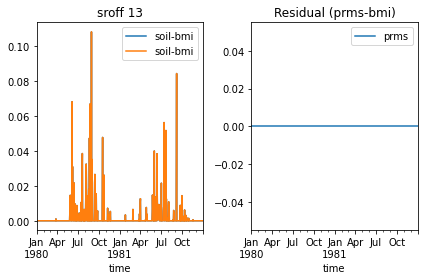

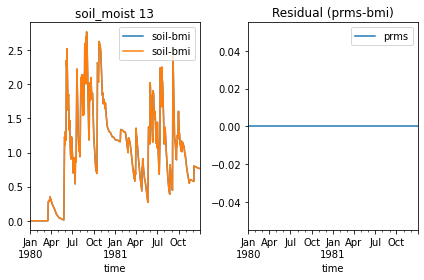

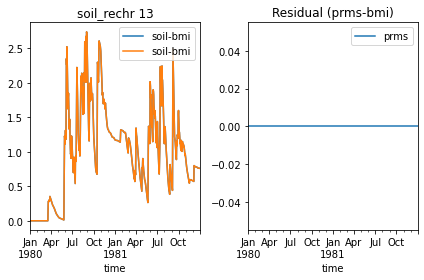

In [16]:
from helper import bmi_prms6_value_plot, bmi_prms6_residual_plot

t_hru = 13

fig, ax = plt.subplots(ncols=2)
bmi_prms6_value_plot(dsoil, t_hru, 'infil', 'soil-bmi', sim_start_date, sim_end_date, ax[0])
bmi_prms6_value_plot(dprms, t_hru, 'infil', 'prms', sim_start_date, sim_end_date, ax[0])
bmi_prms6_residual_plot(dsoil, dprms, t_hru, 'infil', 'prms', sim_start_date, sim_end_date, ax[1])
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(ncols=2)
bmi_prms6_value_plot(dsoil, t_hru, 'sroff', 'soil-bmi', sim_start_date, sim_end_date, ax[0])
bmi_prms6_value_plot(dprms, t_hru, 'sroff', 'soil-bmi', sim_start_date, sim_end_date, ax[0])
bmi_prms6_residual_plot(dsoil, dprms, t_hru, 'sroff', 'prms', sim_start_date, sim_end_date, ax[1])
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(ncols=2)
bmi_prms6_value_plot(dsoil, t_hru, 'soil_moist', 'soil-bmi', sim_start_date, sim_end_date, ax[0])
bmi_prms6_value_plot(dprms, t_hru, 'soil_moist', 'soil-bmi', sim_start_date, sim_end_date, ax[0])
bmi_prms6_residual_plot(dsoil, dprms, t_hru, 'soil_moist', 'prms', sim_start_date, sim_end_date, ax[1])
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(ncols=2)
bmi_prms6_value_plot(dsoil, t_hru, 'soil_rechr', 'soil-bmi', sim_start_date, sim_end_date, ax[0])
bmi_prms6_value_plot(dprms, t_hru, 'soil_rechr', 'soil-bmi', sim_start_date, sim_end_date, ax[0])
bmi_prms6_residual_plot(dsoil, dprms, t_hru, 'soil_rechr', 'prms', sim_start_date, sim_end_date, ax[1])
plt.gca().ticklabel_format(axis='y', style='plain', useOffset=False)
plt.tight_layout()
plt.show()


---
The variables below are the input the the groundwater bmi

---

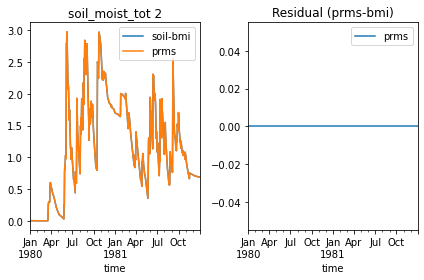

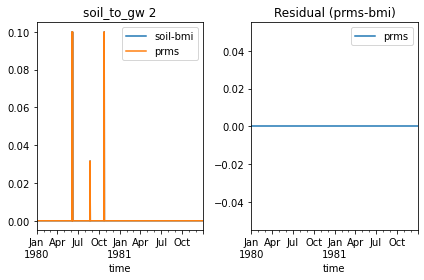

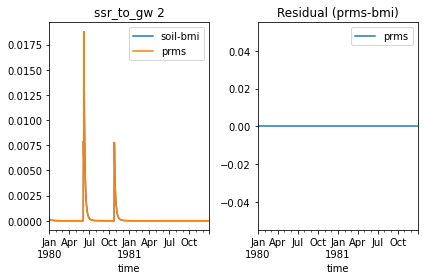

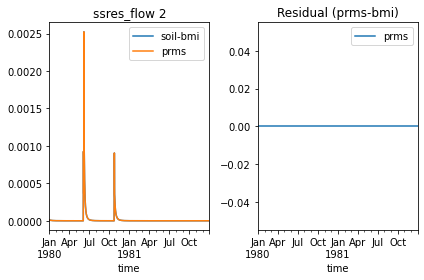

In [17]:
t_hru = 2

fig, ax = plt.subplots(ncols=2)
bmi_prms6_value_plot(dsoil, t_hru, 'soil_moist_tot', 'soil-bmi', sim_start_date, sim_end_date, ax[0])
bmi_prms6_value_plot(dprms, t_hru, 'soil_moist_tot', 'prms', sim_start_date, sim_end_date, ax[0])
bmi_prms6_residual_plot(dsoil, dprms, t_hru, 'soil_moist_tot', 'prms', sim_start_date, sim_end_date, ax[1])
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(ncols=2)
bmi_prms6_value_plot(dsoil, t_hru, 'soil_to_gw', 'soil-bmi', sim_start_date, sim_end_date, ax[0])
bmi_prms6_value_plot(dprms, t_hru, 'soil_to_gw', 'prms', sim_start_date, sim_end_date, ax[0])
bmi_prms6_residual_plot(dsoil, dprms, t_hru, 'soil_to_gw', 'prms', sim_start_date, sim_end_date, ax[1])
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(ncols=2)
bmi_prms6_value_plot(dsoil, t_hru, 'ssr_to_gw', 'soil-bmi', sim_start_date, sim_end_date, ax[0])
bmi_prms6_value_plot(dprms, t_hru, 'ssr_to_gw', 'prms', sim_start_date, sim_end_date, ax[0])
bmi_prms6_residual_plot(dsoil, dprms, t_hru, 'ssr_to_gw', 'prms', sim_start_date, sim_end_date, ax[1])
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(ncols=2)
bmi_prms6_value_plot(dsoil, t_hru, 'ssres_flow', 'soil-bmi', sim_start_date, sim_end_date, ax[0])
bmi_prms6_value_plot(dprms, t_hru, 'ssres_flow', 'prms', sim_start_date, sim_end_date, ax[0])
bmi_prms6_residual_plot(dsoil, dprms, t_hru, 'ssres_flow', 'prms', sim_start_date, sim_end_date, ax[1])
plt.gca().ticklabel_format(axis='y', style='plain', useOffset=False)
plt.tight_layout()
plt.show()

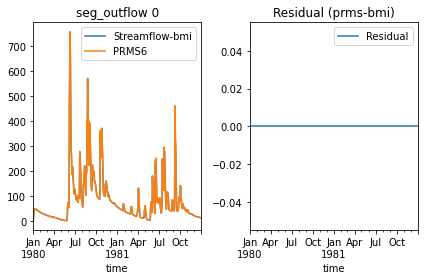

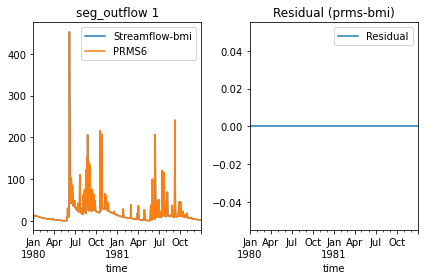

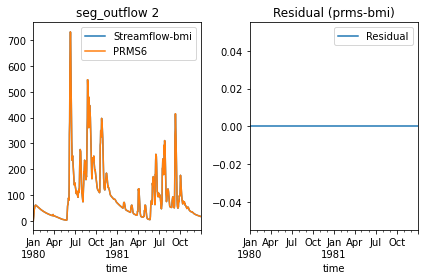

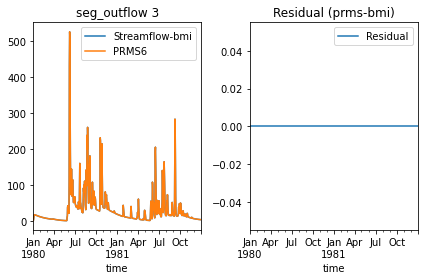

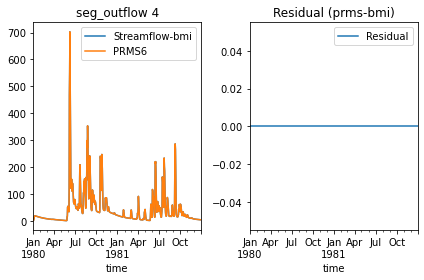

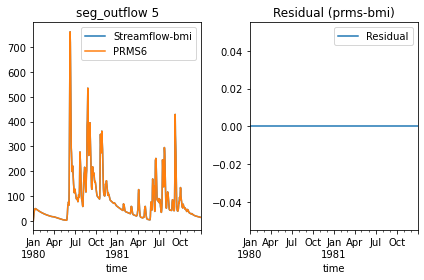

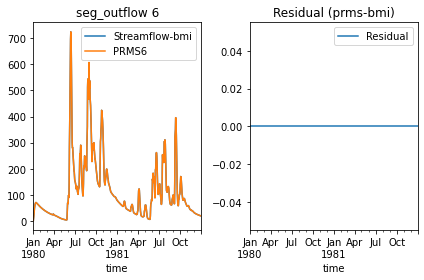

In [18]:
# for seg in dprms.nsegment:
nsegment = dprms['seg_outflow'].sizes['nsegment']
for seg in range(nsegment):
    fig, ax = plt.subplots(ncols=2)
    bmi_prms6_value_plot(dstrm, seg, 'seg_outflow', 'Streamflow-bmi', sim_start_date, sim_end_date, ax[0])
    bmi_prms6_value_plot(dprms, seg, 'seg_outflow', 'PRMS6', sim_start_date, sim_end_date, ax[0])
    bmi_prms6_residual_plot(dstrm, dprms, seg, 'seg_outflow', 'Residual', sim_start_date, sim_end_date, ax[1])
#     plt.legend()
    plt.tight_layout()
    plt.show()